# SNAP TO MAP

In this notebook we explore how we can do *map matching* - or how to go from a set of coordinate locations to a map - using OSMnx.

---
## 1. Load some data to work with

We work with data from the Zendrive schema, featuring actual user trips

In [1]:
import pandas as pd
import psycopg2, os
import matplotlib.pyplot as plt

# Establish connection and create its cursor
try: 
    conn = psycopg2.connect(f"host={os.environ['AURORA_POSTGRES_HOST']} dbname={os.environ['AURORA_POSTGRES_DATABASE']} user={os.environ['AURORA_POSTGRES_USERNAME']} password={os.environ['AURORA_POSTGRES_PWD']}")
    cur = conn.cursor()
except psycopg2.Error as e: 
    print("Error: Could not make connection to the Postgres database")
    print(e)
    

Load tables

In [2]:
# Collect trips table
cur.execute("SELECT * FROM zendrive.trip")
trips = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])

# Collect events table
cur.execute("SELECT * FROM zendrive.event")
events = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])

# Pick one example trip to look up
example_trip = trips[trips['trip_id']==1625850683232].iloc[0]
#example_trip = trips[(trips['score'].between(10, 40)) & 
#                     (trips['distance'].between(5, 10)) & 
#                     (trips['drive_type']=='driver')].iloc[0]
display(example_trip)

# Collect its path
cur.execute(f"SELECT * FROM zendrive.path_point WHERE trip_id={example_trip.trip_id}")
trip_paths = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
print('Total of available trip points:', trip_paths.shape[0])
trip_paths.head()


id                                                       14052
trip_id                                          1625850683232
driver                                                    1041
created_at                          2021-07-09 17:26:23.454922
updated_at                          2021-07-09 18:26:40.306363
started_at                                 2021-07-09 17:11:23
ended_at                                   2021-07-09 17:24:18
distance                                                 6.768
score                                                     38.0
user_feedback                                             None
duration_seconds                                       775.178
trip_max_speed_kmph                                   85.69604
latitude_start                                      -23.066954
longitude_start                                     -47.190296
latitude_end                                        -23.096682
longitude_end                                       -47

Total of available trip points: 102


,trip_internal_id,trip_id,point_order_id,latitude,longitude,point_timestamp,time_millis,trip_created_at,trip_updated_at,point_composed_id,internal_timestamp
0,14052,1625850683232,1,-23.066954,-47.190296,2021-07-09 14:11:23.421,1625850683421,2021-07-09 17:26:23.454922,2021-07-09 18:26:40.306363,14052--1--2021-07-09 18:26:40.306363,2021-10-04 15:54:12.020790
1,14052,1625850683232,2,-23.066984,-47.190228,2021-07-09 14:11:24.000,1625850684425,2021-07-09 17:26:23.454922,2021-07-09 18:26:40.306363,14052--2--2021-07-09 18:26:40.306363,2021-10-04 15:54:12.020790
2,14052,1625850683232,3,-23.066947,-47.190061,2021-07-09 14:11:27.000,1625850687431,2021-07-09 17:26:23.454922,2021-07-09 18:26:40.306363,14052--3--2021-07-09 18:26:40.306363,2021-10-04 15:54:12.020790
3,14052,1625850683232,4,-23.066893,-47.189981,2021-07-09 14:11:27.000,1625850687431,2021-07-09 17:26:23.454922,2021-07-09 18:26:40.306363,14052--4--2021-07-09 18:26:40.306363,2021-10-04 15:54:12.020790
4,14052,1625850683232,5,-23.066893,-47.189981,2021-07-09 14:11:27.000,1625850687431,2021-07-09 17:26:23.454922,2021-07-09 18:26:40.306363,14052--5--2021-07-09 18:26:40.306363,2021-10-04 15:54:12.020790


---
## 2. City networks

### 2.1. Collecting a ceity network graph

OSMnx allows receiving a network of a city by:
- Geocoding the query for the selected city to retrieve the place boundaries from the Nominatim API
- Retrieving the drivable street network data within those boundaries from the Overpass API
- Constructing a graph model (NetworkX MultiDiGraph object)

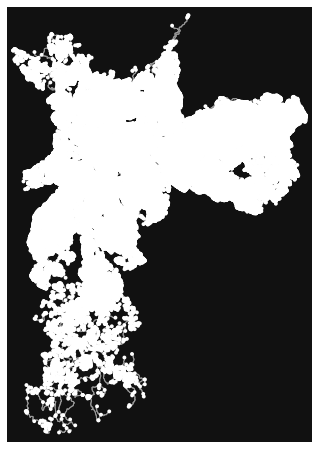

In [8]:
import networkx as nx
import osmnx as ox

# Chose a place to download the network for
place = "Sao Paulo, Brazil"
# place = {"city": "San Francisco", "state": "California", "country": "USA"} --> Use this for less ambiguous queries

# Available network types
network_types = ['drive', # get drivable public streets (but not service roads)
                 'drive_service', # get drivable streets, including service roads
                 'walk', # get all streets and paths that pedestrians can use (this network type ignores one-way directionality)
                 'bike', # get all streets and paths that cyclists can use
                 'all', # download all non-private OSM streets and paths (this is the default network type unless you specify a different one)
                 'all_private', # download all OSM streets and paths, including private-access ones
                ]

# Get the network for our place and our network type
G = ox.graph_from_place(place, network_type=network_types[0])
fig, ax = ox.plot_graph(G)


A few notes:

- **Topological simplification**: By default OSMnx simplifies graphs removing some weirdness in what is received from OpenStreetMap... in case you needed to debug a location graph check section 3 of https://github.com/gboeing/osmnx-examples/blob/main/notebooks/01-overview-osmnx.ipynb

- **Network querying**: This is the easiest way to collect a network but there's many more - using (lon, lat) plus distance, using a bounding box... Check all modes here https://github.com/gboeing/osmnx-examples/blob/main/notebooks/01-overview-osmnx.ipynb

We can save the network model easily

In [12]:
filepath = "data/sao_paulo_network.graphml"

# Save street network as GraphML file to work with later in OSMnx or networkx or gephi
#ox.save_graphml(G, filepath=filepath)

# Load street network back
#G = ox.io.load_graphml(filepath)


The graph model can be converted easily to:
- **Undirected MultiGraph**: `ox.utils_graph.get_undirected(G)`
- **DiGraph**: `ox.utils_graph.get_digraph(G)`
- **GeoPandas node/edge GeoDataFrame**: `gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)`

### 2.2. Network stats

Basic network stats including area, edge densities:
- Documentation: https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats
- Example at https://github.com/gboeing/osmnx-examples/blob/main/notebooks/00-osmnx-features-demo.ipynb

---

## 3. Network structure

Our network is organized in edges and nodes.

In [31]:
# Nodes have a point geometry, with (lon, lat) coordinates and a count of edges connected to them
print("Example node")
display(list(G.nodes.data())[4])

# Edge data is more interesting, featuring all node connections and all relevant road info
print("Example edge")
display(list(G.edges.data())[4])


Example node


(582139, {'y': -23.5346165, 'x': -46.7481485, 'street_count': 3})

Example edge


(577239,
 6549930664,
 {'osmid': [768965403, 710311587, 768965404],
  'oneway': True,
  'lanes': '5',
  'ref': 'SP-015',
  'name': 'Marginal Pinheiros, Pista Local',
  'highway': 'motorway',
  'maxspeed': '90',
  'length': 178.30599999999998,
  'geometry': <shapely.geometry.linestring.LineString at 0x7fc0ff202820>})

## 4. Nearest node/edge search

We can easily collect our nearest node or nearest edge with 